### Notebook Setup

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.width', 1000) #better print view
pd.set_option('display.max_colwidth', 200)

%load_ext autoreload
%autoreload 2

#### Load Dataset from File

The training data containing 3 columns:

* `Text`: Raw input text
* `Label`: Political tendency label (Democratic/Republican/NA)

In [2]:
df = pd.read_csv("../subreddit_dataset_full_labeled_gpt4o.csv", sep=",")

df.head()

,Text,Label
0,"Forensic Audit: ""We conclude that the Dominion Voting System is intentionally and purposefully designed with inherent errors to create systemic fraud and influence election results."" So now that t...",Republican
1,"Biden and The Squad's Tlaib stage heated confrontation on tarmac in Detroit. Tlaib, your family is Hamas. Funded by Iran a state sponsor of terrorism. Hamas is a terrorist organization 3000 rocket...",Republican
2,"President-elect Biden is projected to win Pennsylvania and Nevada, putting him over 270 electoral votes. Most Republicans are happy with Biden as he will bring this country together and will have ...",NaN
3,Not even an issue of politics it's wrong this man is being charged. What is going to happen with this trend is that police will not risk getting charged and will not use their weapon unless it is ...,Republican
4,"Young man wearing MAGA hat attacked at school and spit on by two girls / animals. He deserves justice! We gotta start normalizing defending ourselves against women. Screw all that ""they're weaker""...",Republican


In [3]:
print("Number of samples: {}".format(len(df)))

#remove whitespaces from df
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)
print(f"Unique labels: {df['Label'].unique()}")

Number of samples: 14048
Unique labels: ['Republican' nan 'Democratic' 'NA']


Let's exclude NA (Not Applicable) labels from the dataset

In [4]:
# 删除所有有缺失值（NaN）的行，包括 Text 和 Label
df = df.dropna()

# 删除标签值为字符串 "NA" 的行（注意不是空值，而是实际写成 "NA" 的字符串）
df = df[df["Label"] != "NA"]

# 把文字标签转成数字（0=Republican，1=Democratic）
df['Label'] = df['Label'].map({'Republican': 1, 'Democratic': 0})
df.head()


,Text,Label
0,"Forensic Audit: ""We conclude that the Dominion Voting System is intentionally and purposefully designed with inherent errors to create systemic fraud and influence election results."" So now that t...",1
1,"Biden and The Squad's Tlaib stage heated confrontation on tarmac in Detroit. Tlaib, your family is Hamas. Funded by Iran a state sponsor of terrorism. Hamas is a terrorist organization 3000 rocket...",1
3,Not even an issue of politics it's wrong this man is being charged. What is going to happen with this trend is that police will not risk getting charged and will not use their weapon unless it is ...,1
4,"Young man wearing MAGA hat attacked at school and spit on by two girls / animals. He deserves justice! We gotta start normalizing defending ourselves against women. Screw all that ""they're weaker""...",1
6,"Trump says working on a very big trade deal with India, but will take time. India is, rightful, where we should pay a significant amount of our attention when it comes to that side of the world.",1


In [5]:
print("Number of samples: {}".format(len(df)))

Number of samples: 10979


Let's visualize the distribution of class labels in form of a pie chart.

<Axes: >

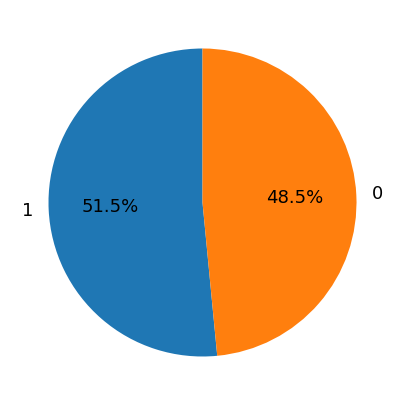

In [6]:
kwargs = dict(
    startangle = 90,
    fontsize   = 13,
    figsize    = (60,5),
    autopct    = '%1.1f%%',
    label      = ''
)

df['Label'].value_counts().plot.pie(**kwargs)

While not perfectly distributed, the class labels are arguebly well balanced.

#### Data Preparation

Text Preprocessing

In [7]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

LEMMATIZER = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words('english'))
#define custom stop words to ensure negation words are kept
WORDS_TO_KEEP = {'not', 'but', 'no', 'never', 'none', 'however', 'although', 'yet'}
CUSTOM_STOP_WORDS = STOP_WORDS.difference(WORDS_TO_KEEP)

#text preprocessing including case normalization, special character removal, lematization, etc.
def preprocess(text):
    # Lowercase and remove URLs/special characters
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s.?!.]', '', text)
    
    text = re.sub(r'(?<!\w)[.?!](?!\s|$)', '', text) #remove punctuation that is not at the end of a word
    
    # Remove repetitive characters e.g: looool -> lol. hahaha-> haha
    #text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'([a-z][a-z])\1+', r'\1\1', text)
    
    # Tokenize and lemmatize
    tokens = word_tokenize(text)
    tokens = [LEMMATIZER.lemmatize(word) for word in tokens]
    
    #Merge back tokens
    result = ""
    for i, token in enumerate(tokens):
        if i > 0 and re.match(r'[.?!,;:]', token):
            result += token  # No space before punctuation
        else:
            result += (" " if result else "") + token #space before word, no space at beginning.
    return result.strip()

df_clean = df.copy()
df_clean['Text'] =  df_clean['Text'].apply(preprocess)
df_clean['Text'] = df_clean['Text'].str.strip()
df_clean.head(5)


,Text,Label
0,forensic audit we conclude that the dominion voting system is intentionally and purposefully designed with inherent error to create systemic fraud and influence election result. so now that they h...,1
1,biden and the squad tlaib stage heated confrontation on tarmac in detroit. tlaib your family is hamas. funded by iran a state sponsor of terrorism. hamas is a terrorist organization rocket shot at...,1
3,not even an issue of politics it wrong this man is being charged. what is going to happen with this trend is that police will not risk getting charged and will not use their weapon unless it is ab...,1
4,young man wearing maga hat attacked at school and spit on by two girl animal. he deserves justice! we got ta start normalizing defending ourselves against woman. screw all that theyre weaker b the...,1
6,trump say working on a very big trade deal with india but will take time. india is rightful where we should pay a significant amount of our attention when it come to that side of the world.,1


In [8]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

In [9]:
# 1️⃣ 分词：把每个文本变成 token 列表（供 Word2Vec 用）
tokenized_corpus = df_clean['Text'].apply(word_tokenize).tolist()
tokenized_corpus

[['forensic',
  'audit',
  'we',
  'conclude',
  'that',
  'the',
  'dominion',
  'voting',
  'system',
  'is',
  'intentionally',
  'and',
  'purposefully',
  'designed',
  'with',
  'inherent',
  'error',
  'to',
  'create',
  'systemic',
  'fraud',
  'and',
  'influence',
  'election',
  'result',
  '.',
  'so',
  'now',
  'that',
  'they',
  'have',
  'elected',
  'biden',
  'how',
  'can',
  'we',
  'have',
  'faith',
  'in',
  'our',
  'election',
  'process',
  'especially',
  'since',
  'they',
  'didnt',
  'listen',
  'to',
  'the',
  'evidence',
  'of',
  'fraud',
  'and',
  'chose',
  'to',
  'ignore',
  'and',
  'discredit',
  'any',
  'mention',
  'of',
  'it',
  '.'],
 ['biden',
  'and',
  'the',
  'squad',
  'tlaib',
  'stage',
  'heated',
  'confrontation',
  'on',
  'tarmac',
  'in',
  'detroit',
  '.',
  'tlaib',
  'your',
  'family',
  'is',
  'hamas',
  '.',
  'funded',
  'by',
  'iran',
  'a',
  'state',
  'sponsor',
  'of',
  'terrorism',
  '.',
  'hamas',
  'is',

In [10]:
# 2️⃣ 训练 Word2Vec 模型
w2v_model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=150,     # 每个词的向量维度（你可以改成50, 200等）
    window=5,            # 上下文窗口大小
    min_count=2,         # 词频小于2的词会被忽略
    workers=4,           # 用多少CPU线程训练
    sg=1,                 # 1 = skip-gram，0 = CBOW，skip-gram 通常效果更好
	epochs=20  # 👈 加上这个
)

# 3️⃣ 定义函数：把一句话的词向量平均，作为句子向量
def sentence_to_vec(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if not vectors:
        return np.zeros(model.vector_size)  # 如果句子没有有效词，就返回全零
    return np.mean(vectors, axis=0)

# 4️⃣ 构建 X 和 y
X = np.array([sentence_to_vec(tokens, w2v_model) for tokens in tokenized_corpus])
y = df_clean['Label'].values
print(X.shape, y.shape)

(10979, 150) (10979,)


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [12]:
# 1️⃣ 拆分训练集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(
	X, y, test_size=0.2, stratify=y, random_state=88)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=88)

print(f"Size of X_train: {X_train.shape[0]}")
print(f"Size of X_val: {X_val.shape[0]}")
print(f"Size of X_test: {X_test.shape[0]}")

Size of X_train: 8783
Size of X_val: 1098
Size of X_test: 1098


In [13]:

# 2️⃣ 初始化并训练逻辑回归模型
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)
# 3️⃣ 在测试集上预测
y_pred = clf.predict(X_test)
# 4️⃣ 输出准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.6903


In [14]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    random_state=42,
    min_samples_leaf=2,      # 防止过拟合（可调）
    max_features='sqrt'      # 更常见的做法
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.6949


In [15]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7049


#### TF-IDF

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus_str = df_clean['Text'].tolist() # 一句句文本
tfidf = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None)
tfidf.fit(corpus_str)
tfidf_weights = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))
def weighted_sentence_vector(tokens, model, tfidf_weights):
    vecs = []
    for token in tokens:
        if token in model.wv and token in tfidf_weights:
            weight = tfidf_weights[token]
            vecs.append(model.wv[token] * weight)
    if not vecs:
        return np.zeros(model.vector_size)
    return np.mean(vecs, axis=0)
X = np.array([
    weighted_sentence_vector(tokens, w2v_model, tfidf_weights)
    for tokens in tokenized_corpus
])
y = df_clean['Label'].values

In [17]:
X_train, X_temp, y_train, y_temp = train_test_split(
	X, y, test_size=0.2, stratify=y, random_state=88)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=88)

print(f"Size of X_train: {X_train.shape[0]}")
print(f"Size of X_val: {X_val.shape[0]}")
print(f"Size of X_test: {X_test.shape[0]}")

Size of X_train: 8783
Size of X_val: 1098
Size of X_test: 1098


In [18]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    random_state=42,
    min_samples_leaf=2,      # 防止过拟合（可调）
    max_features='sqrt'      # 更常见的做法
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7104
